# Método de regresión multivareada

## Life Expectancy
Life Expectancy is the lenght of time that a human being is likely to live, here we will analyze data collected by the WHO and United Nations to estimate life expectancy. Implementing a multivariate linear regression model using gradient descent to predict life expectacy as a function of multiple characteristics.

## 1. Import of libraries and data loading

In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
url = "https://raw.githubusercontent.com/DiegoIraheta00041923/datasetAN/refs/heads/main/Life%20Expectancy%20Data.csv"
#Loading data from csv file
df = pd.read_csv(url)
#Preview
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## 2. Data cleaning and preparation
Certain factors are taken during the data cleaning process:
 - Identification of total missing values per column.
 - Replacement of null values using the mean for numerical variables.

This step is esential to ensure the quality of the data before to proceeding with the construction of the regression model

In [5]:
#Calculation of missing values 
total_missing_values = df.isnull().sum().sum()
missing_per_column = df.isnull().sum().sort_values(ascending=False)
print(f"Datos ausentes en celdas del archivo: {total_missing_values}")
print("Datos ausentes por columnas:")
print(missing_per_column)

#The null values are replaced with the mean of each numerical column.
df.fillna(df.mean(numeric_only=True),inplace = True)
# Fill Status with the most common value (trend)
most_common_status = df['Status'].mode()[0]
df['Status'] = df['Status'].fillna(most_common_status)
# Transformation to 0 or 1
df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})


#Drop irrelevant columns
#Country since it is a nominal identifier with no predictive value.
#Developing is no longer required due to the transformation of Status
df.drop(columns=['Country'], inplace = True)

constant_columns = df.loc[:, df.nunique() <= 1].columns
df = df.drop(columns=constant_columns)

# fill in missing values
df = df.fillna(df.mean(numeric_only=True))

Datos ausentes en celdas del archivo: 2563
Datos ausentes por columnas:
Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
 thinness  1-19 years               34
 thinness 5-9 years                 34
 BMI                                34
Diphtheria                          19
Polio                               19
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Status                               0
Country                              0
Year                                 0
under-five deaths                    0
Measles                              0
percentage expenditure               0
 HIV/AIDS                            0
dtype: int64


## 3. Exploratory Analysis

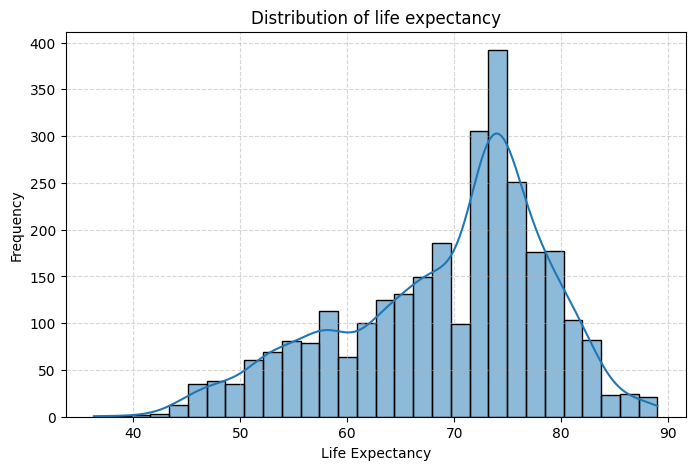

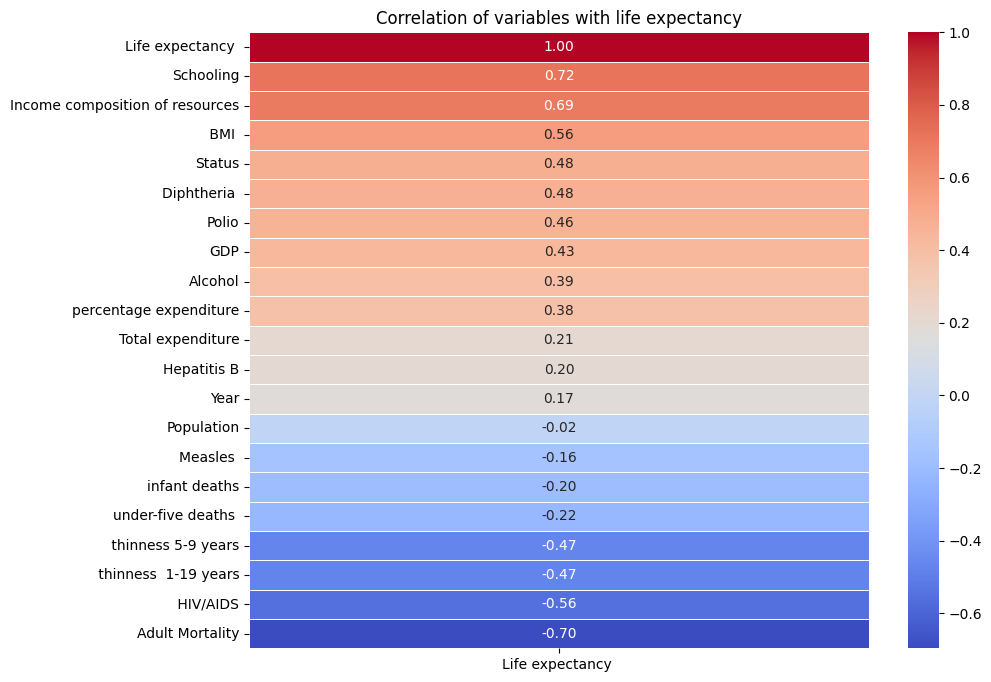

In [7]:
# Distribution of the target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['Life expectancy '], kde=True, bins=30)
plt.title("Distribution of life expectancy")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#It is ensured that only numeric columns will be used
df_numeric = df.select_dtypes(include=[np.number])
#Correlation matrix
correlation_matrix = df_numeric.corr()
#Filtering by correlations of the variable Life expectancy
corr_with_target = correlation_matrix[['Life expectancy ']].sort_values(by = 'Life expectancy ', ascending = False)

#Display
plt.figure(figsize=(10,8))
sns.heatmap(corr_with_target, annot = True, cmap='coolwarm',linewidths=0.5, fmt=".2f")
plt.title("Correlation of variables with life expectancy")
plt.show()


# Model implementation
## 4. Data Preparation
At this stage, the data set to be used in the multivaratie linear regression model is prepared, therefore the variable to be predicted, in this case, life expectancy, is separated.

In [8]:
# The target (dependent) variable to be predicted is defined: life expectancy.
y = df['Life expectancy '].values.reshape(-1, 1)

# Predictor (independent) variables are defined, eliminating the target column.
X = df.drop(columns=['Life expectancy '])
X = X.fillna(X.mean(numeric_only=True))  # Solo columnas numéricas
y = df['Life expectancy '].fillna(df['Life expectancy '].mean()).values.reshape(-1, 1)
feature_names = X.columns.tolist()

# Standardization of the characteristics: they are scaled to mean 0 and standard deviation 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Division of the data into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Parameter initialization
To calculate the model prediction using the downward gradient, the following function is used
$\hat{y}$ =  $X$ $\cdot$ $\theta$

In [9]:
def initialize_params(n_features):
    theta = np.zeros((n_features,1))
    return theta

In [10]:
#Calculates linear model predictions
def predict(X, theta):
    return X @ theta

 The cost function quantifies how good the model predictions are compared to the actual values. In this case, the Mean Squared Error (MSE) is used.
which will be used in this formula:\
$ J(\theta)$ = $\frac{1}{2m}$ $\sum_{i=1}^{m}$ ($\hat{y}^{(i)}$- $y^{(i)}$) $^{2}$ where: \
$m$ number of examples \
$\hat{y}^{(i)}$ is the prediction for the example $i$ \
$y^{(i)}$ is the real value

In [11]:
def compute_cost(X, y, theta):
    m = len(y)
    predictions = predict(X, theta)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

Gradient descent is an iterative algorithm to optimize the parameters of the $\theta$ model with the objective of minimizing the cost function. $J(\theta)$ \
 $\nabla_\theta J(\theta) = \frac{1}{m}X^{T}(X\theta - y)$ 

In [12]:
#gradient descent
def gradient_descent(X,y,theta,alpha,epochs):
    m=len(y)
    cost_history= []

    for i in range(epochs):
        predictions = predict(X, theta) #makes the prediction
        error = predictions - y #calculates error
        gradient = (1/m)*X.T @ error #calculate gradient
        theta -= alpha * gradient #update parameters
        cost = compute_cost(X,y,theta) #save the cost
        cost_history.append(cost) #Records cost history
    return theta, cost_history

## 5. Model training

In [13]:
#add ones column for the independent term (bias)
X_train_bias = np.hstack([np.ones((X_train.shape[0],1)), X_train])
X_test_bias = np.hstack([np.ones((X_test.shape[0],1)), X_test])
#Initialize theta
theta_init = initialize_params(X_train_bias.shape[1])
#Training
alpha = 0.01
epochs = 1000
theta_final, cost_history = gradient_descent(X_train_bias, y_train, theta_init, alpha, epochs)

The following graph will show how the cost function (MSE) evolves throughout the iterations

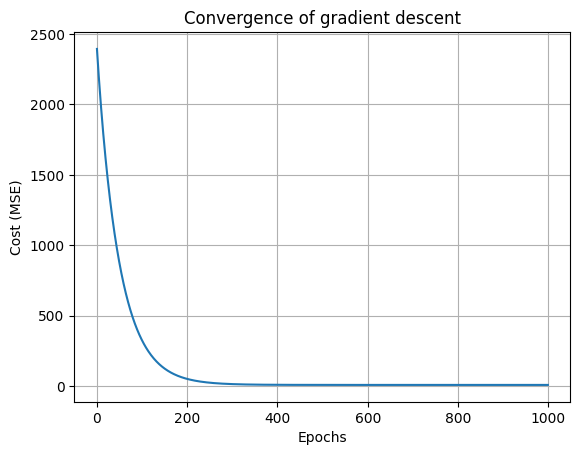

In [14]:
plt.plot(range(epochs), cost_history)
plt.xlabel("Epochs")
plt.ylabel("Cost (MSE)")
plt.title("Convergence of gradient descent")
plt.grid(True)
plt.show()

It can be observed that the curve descends rapidly and then ends up being a little more constant, indicating that we have reached a near minimum of the error.

Certain metrics will be used to determine the accuracy of the model such as the Mean Absolute Error (MAE) \
$\text{MAE} = \frac{1}{m} \sum_{i=1}^{m} \left| \hat{y}^{(i)} - y^{(i)} \right|$

In [15]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

To measure how well the model explains the variability of the target variable, the Coefficient of Determination will be used. $(R^2)$ \
$ R^2 = 1 - \frac{\sum_{i=1}^{m} \left( y^{(i)} - \hat{y}^{(i)} \right)^2}{\sum_{i=1}^{m} \left( y^{(i)} - \bar{y} \right)^2} $

In [16]:
def r2_score(y_true, y_pred):
    sum_up = np.sum((y_true - y_pred)**2)
    sum_down = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (sum_up/sum_down)

## Model evaluation 

In [18]:
# X_train and X_test scale using these values
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  
# Add ones column for bias
X_train_scaled = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_scaled = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])
y_predicted = predict(X_test_scaled, theta_final)

mae = mean_absolute_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

print(f"MAE: {mae:.2f}")
print(f"r^2: {r2:.2f}")

MAE: 2.95
r^2: 0.81


## Model visualization

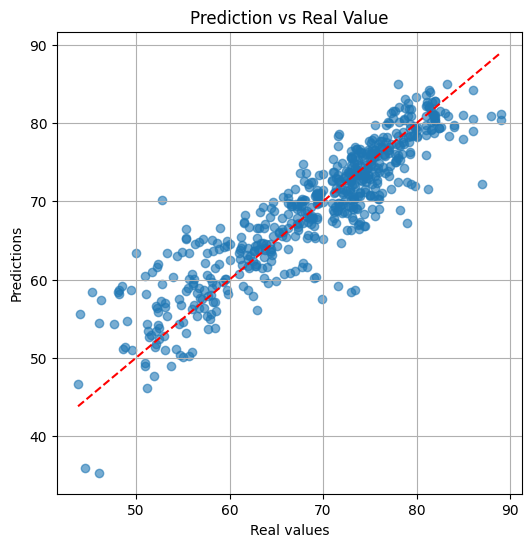

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_predicted, alpha = 0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Real values")
plt.ylabel("Predictions")
plt.title("Prediction vs Real Value")
plt.grid(True)
plt.show()

## Conclusions
By using a multivariate linear regression model, in this case using gradient descent to predict life expectancy, we have found the performance of this model to be satisfactory, reaching a Mean Absolute Error (MAE) of 2.95 years, indicating that the model predictions deviate less than 3 years from the actual values. Similarly, with 0.81 in the coefficient of determination ${R^2}$, we can say that 81% of the variability of life expectancy can be explained by the variables in the model. With schooling and resource income composition being the variables most related to life expectancy. This indicates that the level of education and access to economic resources have a great impact on the longevity of populations.